# Project 1

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
num_classes = 10
input_shape=(28, 28, 1)
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test_samples")
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape (60000, 28, 28, 1)
60000 train samples
10000 test_samples


In [4]:
model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

In [5]:
batch_size = 128
epochs = 15
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 37s 86ms/step - loss: 0.3543 - accuracy: 0.8938 - val_loss: 0.0799 - val_accuracy: 0.9785
Epoch 2/15
422/422 [==============================] - 36s 85ms/step - loss: 0.1115 - accuracy: 0.9660 - val_loss: 0.0586 - val_accuracy: 0.9827
Epoch 3/15
422/422 [==============================] - 36s 85ms/step - loss: 0.0838 - accuracy: 0.9743 - val_loss: 0.0489 - val_accuracy: 0.9853
Epoch 4/15
422/422 [==============================] - 36s 85ms/step - loss: 0.0711 - accuracy: 0.9771 - val_loss: 0.0429 - val_accuracy: 0.9883
Epoch 5/15
422/422 [==============================] - 36s 85ms/step - loss: 0.0641 - accuracy: 0.9793 - val_loss: 0.0405 - val_accuracy: 0.9888
Epoch 6/15
422/422 [==============================] - 36s 85ms/step - loss: 0.0565 - accuracy: 0.9827 - val_loss: 0.0361 - val_accuracy: 0.9898
Epoch 7/15
422/422 [==============================] - 36s 85ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0355 - val_accuracy:

In [6]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.02536499872803688
Test accuracy: 0.9914000034332275


# Project 2

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("D:/datasets_CSV/kagglecatsanddogs_3367a/PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()
        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)
print("deleted %d images" %num_skipped)

deleted 0 images


In [3]:
image_size = (180, 180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory("D:/datasets_CSV/kagglecatsanddogs_3367a/PetImages", 
                                validation_split=0.2, subset="training", seed=1337, image_size=image_size, 
                                                               batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory("D:/datasets_CSV/kagglecatsanddogs_3367a/PetImages", 
                                                             validation_split=0.2,
                                                            subset="validation", seed=1337, image_size=image_size, 
                                                             batch_size=batch_size)

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


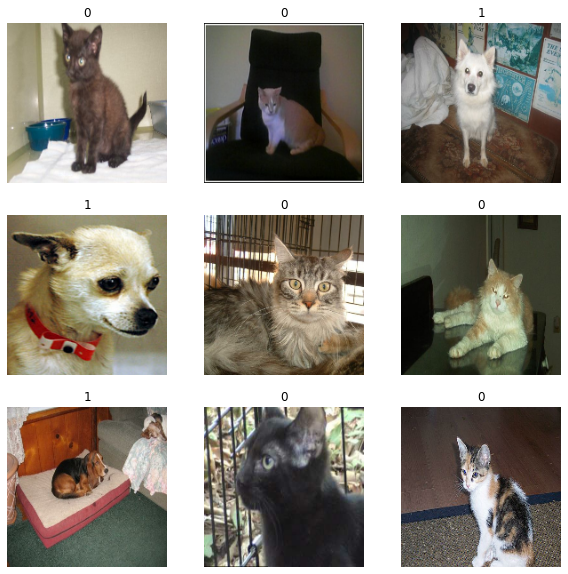

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [5]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

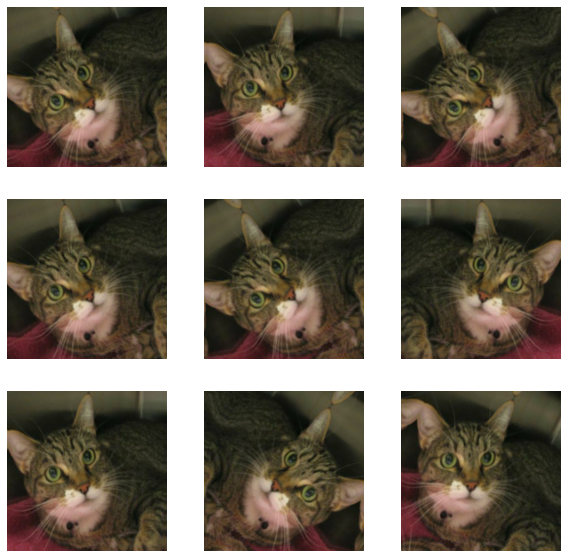

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [8]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [9]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x
    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3, ), num_classes=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[1][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling_1[0][0]']        

 batch_normalization_7 (BatchNo  (None, 23, 23, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 512)  0          ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_4 (Conv2D)              (None, 12, 12, 512)  131584      ['add_1[0][0]']                  
                                                                                                  
 add_2 (Add)                    (None, 12, 12, 512)  0           ['max_pooling2d_2[0][0]',        
                                                                  'conv2d_4[0][0]']               
                                                                                                  
 activatio

In [11]:
epochs = 50
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/50
586/586 [==============================] - 3949s 7s/step - loss: 0.6335 - accuracy: 0.6563 - val_loss: 0.5112 - val_accuracy: 0.7558
Epoch 2/50
586/586 [==============================] - 2904s 5s/step - loss: 0.4739 - accuracy: 0.7795 - val_loss: 0.8311 - val_accuracy: 0.6808
Epoch 3/50
586/586 [==============================] - 2957s 5s/step - loss: 0.3878 - accuracy: 0.8272 - val_loss: 0.5696 - val_accuracy: 0.7780
Epoch 4/50
586/586 [==============================] - 3376s 6s/step - loss: 0.3279 - accuracy: 0.8587 - val_loss: 0.4607 - val_accuracy: 0.8301
Epoch 5/50
586/586 [==============================] - 2965s 5s/step - loss: 0.2727 - accuracy: 0.8873 - val_loss: 0.3548 - val_accuracy: 0.8527
Epoch 6/50
586/586 [==============================] - 2797s 5s/step - loss: 0.2349 - accuracy: 0.9026 - val_loss: 0.8603 - val_accuracy: 0.7148
Epoch 7/50
586/586 [==============================] - 2796s 5s/step - loss: 0.2076 - accuracy: 0.9139 - val_loss: 0.3497 - val_accuracy:

In [12]:
img = keras.preprocessing.image.load_img("D:/datasets_CSV/kagglecatsanddogs_3367a/PetImages/Cat/6779.jpg", 
                                         target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = predictions[0]
print("This image is %.2f percent cat and %.2f percent dog."%(100 * (1 - score), 100 * score))

This image is 47.59 percent cat and 52.41 percent dog.


# Project 3

In [2]:
import os 
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

'C:\\Users\\jatin\\CT-0.zip'

In [4]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

1045176320/1045162547 [==============================] - 1564s 1us/step


'C:\\Users\\jatin\\CT-23.zip'

In [5]:
os.makedirs("MosMedData")
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData")
with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData")

In [17]:
import nibabel as nib
from scipy import ndimage
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume-min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1/ depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

In [18]:
normal_scan_paths = [os.path.join(os.getcwd(), "MosMedData/CT-0", x) for x in os.listdir("MosMedData/CT-0")]
abnormal_scan_paths = [os.path.join(os.getcwd(), "MosMedData/CT-23", x) for x in os.listdir("MosMedData/CT-23")]
print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [21]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])


In [22]:
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)

In [23]:
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)

In [24]:
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)

In [25]:
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

In [26]:
print("Number of samples in train and validation are %d and %d"%(x_train.shape[0], x_val.shape[0]))

Number of samples in train and validation are 140 and 60


In [30]:
from scipy import ndimage
import random
@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume
def train_preprocessing(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [31]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))
batch_size = 2
train_dataset = (train_loader.shuffle(len(x_train)).map(train_preprocessing).batch(batch_size).prefetch(2))
validation_dataset = (validation_loader.shuffle(len(x_val)).map(validation_preprocessing).batch(batch_size).prefetch(2))

Dimension of the CT scan is: (128, 128, 64, 1)


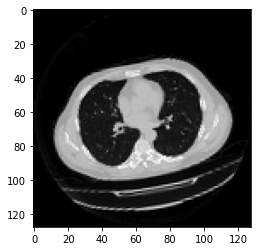

In [32]:
import matplotlib.pyplot as plt
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

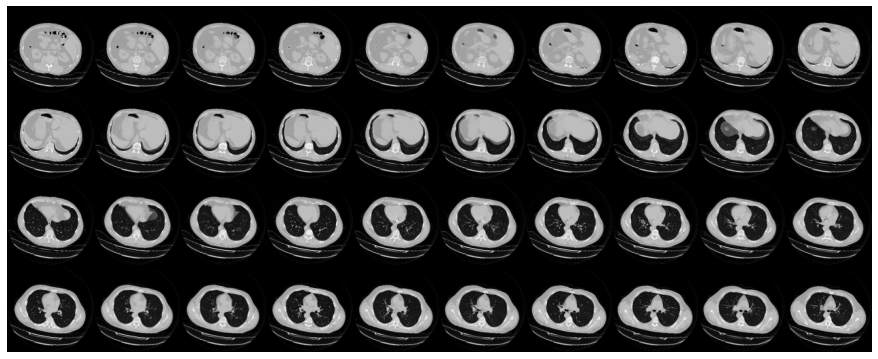

In [34]:
def plot_slices(num_rows, num_columns, width, height, data):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(rows_data, columns_data, figsize=(fig_width, fig_height), gridspec_kw = 
                            {"height_ratios":heights})
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
plot_slices(4, 10, 128, 128, image[:, :, :40])

In [39]:
def get_model(width=128, height=128, depth=64):
    inputs = keras.Input((width, height, depth, 1))
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(units=1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d_14 (Conv3D)          (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d_14 (MaxPoolin  (None, 63, 63, 31, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 63, 63, 31, 64)   256       
 chNormalization)                                                
                                                                 
 conv3d_15 (Conv3D)          (None, 61, 61, 29, 64)    110656    
                                                             

In [45]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, 
                                                          staircase=True)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), loss="binary_crossentropy", 
              metrics=["accuracy"])
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
epochs = 100
model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, shuffle=True, 
          verbose=2, callbacks=[early_stopping_cb])

Epoch 1/100
70/70 - 2570s - loss: 0.7076 - accuracy: 0.5643 - val_loss: 0.6922 - val_accuracy: 0.5000 - 2570s/epoch - 37s/step
Epoch 2/100
70/70 - 1348s - loss: 0.6653 - accuracy: 0.6071 - val_loss: 0.9361 - val_accuracy: 0.5000 - 1348s/epoch - 19s/step
Epoch 3/100
70/70 - 1380s - loss: 0.6830 - accuracy: 0.5714 - val_loss: 1.4402 - val_accuracy: 0.5000 - 1380s/epoch - 20s/step
Epoch 4/100
70/70 - 1374s - loss: 0.6882 - accuracy: 0.5500 - val_loss: 1.1636 - val_accuracy: 0.5000 - 1374s/epoch - 20s/step
Epoch 5/100
70/70 - 1373s - loss: 0.6275 - accuracy: 0.6857 - val_loss: 0.9509 - val_accuracy: 0.5000 - 1373s/epoch - 20s/step
Epoch 6/100
70/70 - 1376s - loss: 0.6347 - accuracy: 0.6429 - val_loss: 1.1098 - val_accuracy: 0.5000 - 1376s/epoch - 20s/step
Epoch 7/100
70/70 - 2721s - loss: 0.6705 - accuracy: 0.6000 - val_loss: 0.8955 - val_accuracy: 0.5000 - 2721s/epoch - 39s/step
Epoch 8/100
70/70 - 3201s - loss: 0.6500 - accuracy: 0.6429 - val_loss: 0.6411 - val_accuracy: 0.6333 - 3201s/e

Epoch 31/100
70/70 - 1309s - loss: 0.4916 - accuracy: 0.8143 - val_loss: 0.9578 - val_accuracy: 0.6000 - 1309s/epoch - 19s/step
Epoch 32/100
70/70 - 1310s - loss: 0.4890 - accuracy: 0.7857 - val_loss: 0.4945 - val_accuracy: 0.7667 - 1310s/epoch - 19s/step
Epoch 33/100
70/70 - 1309s - loss: 0.5154 - accuracy: 0.7429 - val_loss: 0.5076 - val_accuracy: 0.7333 - 1309s/epoch - 19s/step
Epoch 34/100
70/70 - 1310s - loss: 0.4899 - accuracy: 0.7500 - val_loss: 0.4029 - val_accuracy: 0.7833 - 1310s/epoch - 19s/step
Epoch 35/100
70/70 - 1307s - loss: 0.4818 - accuracy: 0.7643 - val_loss: 0.5740 - val_accuracy: 0.7000 - 1307s/epoch - 19s/step
Epoch 36/100
70/70 - 1307s - loss: 0.4357 - accuracy: 0.7643 - val_loss: 0.4606 - val_accuracy: 0.7333 - 1307s/epoch - 19s/step
Epoch 37/100
70/70 - 1305s - loss: 0.4949 - accuracy: 0.7429 - val_loss: 2.4010 - val_accuracy: 0.5000 - 1305s/epoch - 19s/step
Epoch 38/100
70/70 - 1306s - loss: 0.4775 - accuracy: 0.8000 - val_loss: 0.6347 - val_accuracy: 0.6833 -

70/70 - 1330s - loss: 0.2751 - accuracy: 0.8786 - val_loss: 0.9516 - val_accuracy: 0.6500 - 1330s/epoch - 19s/step
Epoch 61/100
70/70 - 1370s - loss: 0.2811 - accuracy: 0.8714 - val_loss: 0.4713 - val_accuracy: 0.8500 - 1370s/epoch - 20s/step
Epoch 62/100
70/70 - 1362s - loss: 0.2658 - accuracy: 0.8857 - val_loss: 1.8743 - val_accuracy: 0.5333 - 1362s/epoch - 19s/step
Epoch 63/100
70/70 - 3205s - loss: 0.3302 - accuracy: 0.8786 - val_loss: 0.6123 - val_accuracy: 0.7167 - 3205s/epoch - 46s/step
Epoch 64/100
70/70 - 3207s - loss: 0.3038 - accuracy: 0.8714 - val_loss: 0.5745 - val_accuracy: 0.7333 - 3207s/epoch - 46s/step
Epoch 65/100
70/70 - 2581s - loss: 0.2769 - accuracy: 0.8643 - val_loss: 0.5792 - val_accuracy: 0.7167 - 2581s/epoch - 37s/step
Epoch 66/100
70/70 - 1355s - loss: 0.3036 - accuracy: 0.8857 - val_loss: 0.5577 - val_accuracy: 0.7667 - 1355s/epoch - 19s/step
Epoch 67/100
70/70 - 1371s - loss: 0.2722 - accuracy: 0.8857 - val_loss: 0.4606 - val_accuracy: 0.8167 - 1371s/epoch 

70/70 - 1310s - loss: 0.1979 - accuracy: 0.9429 - val_loss: 0.7116 - val_accuracy: 0.7000 - 1310s/epoch - 19s/step
Epoch 91/100
70/70 - 1310s - loss: 0.1516 - accuracy: 0.9143 - val_loss: 0.6282 - val_accuracy: 0.7500 - 1310s/epoch - 19s/step
Epoch 92/100
70/70 - 1310s - loss: 0.1823 - accuracy: 0.9357 - val_loss: 0.6089 - val_accuracy: 0.8000 - 1310s/epoch - 19s/step
Epoch 93/100
70/70 - 1308s - loss: 0.2218 - accuracy: 0.9071 - val_loss: 0.6313 - val_accuracy: 0.8500 - 1308s/epoch - 19s/step
Epoch 94/100
70/70 - 1311s - loss: 0.1859 - accuracy: 0.9286 - val_loss: 0.5353 - val_accuracy: 0.7833 - 1311s/epoch - 19s/step
Epoch 95/100
70/70 - 1312s - loss: 0.1911 - accuracy: 0.9143 - val_loss: 1.2229 - val_accuracy: 0.7167 - 1312s/epoch - 19s/step
Epoch 96/100
70/70 - 1309s - loss: 0.1272 - accuracy: 0.9500 - val_loss: 0.7006 - val_accuracy: 0.7500 - 1309s/epoch - 19s/step
Epoch 97/100
70/70 - 1309s - loss: 0.1363 - accuracy: 0.9500 - val_loss: 0.5470 - val_accuracy: 0.7833 - 1309s/epoch 

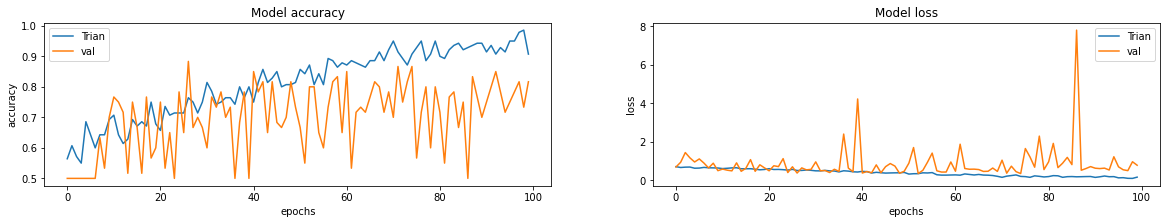

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()
for i, metric in enumerate(["accuracy", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["Trian", "val"])

In [51]:
predictions = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - predictions[0], predictions[0]]
class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print("This model is %.2f percent confident that CT scan is %s"%((100 * score), name))

This model is 1.16 percent confident that CT scan is normal
This model is 98.84 percent confident that CT scan is abnormal


# Projects 4

In [22]:
import os
input_dir = "D:/datasets_CSV/images"
target_dir = "D:/datasets_CSV/annotations/trimaps"
img_size = (160, 160)
num_classes = 3
batch_size = 32
input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])

In [23]:
get_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) 
                        if fname.endswith(".png") and not fname.startswith(".")])

In [24]:
print("Number of samples:", len(input_img_paths))
for input_path, target_path in zip(input_img_paths[:10], get_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
D:/datasets_CSV/images\Abyssinian_1.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_1.png
D:/datasets_CSV/images\Abyssinian_10.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_10.png
D:/datasets_CSV/images\Abyssinian_100.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_100.png
D:/datasets_CSV/images\Abyssinian_101.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_101.png
D:/datasets_CSV/images\Abyssinian_102.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_102.png
D:/datasets_CSV/images\Abyssinian_103.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_103.png
D:/datasets_CSV/images\Abyssinian_104.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_104.png
D:/datasets_CSV/images\Abyssinian_105.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_105.png
D:/datasets_CSV/images\Abyssinian_106.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_106.png
D:/datasets_CSV/images\Abyssinian_107.jpg | D:/datasets_CSV/annotations/trimaps\Abyssinian_

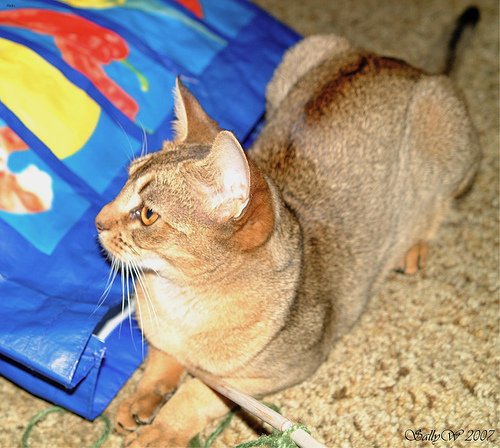

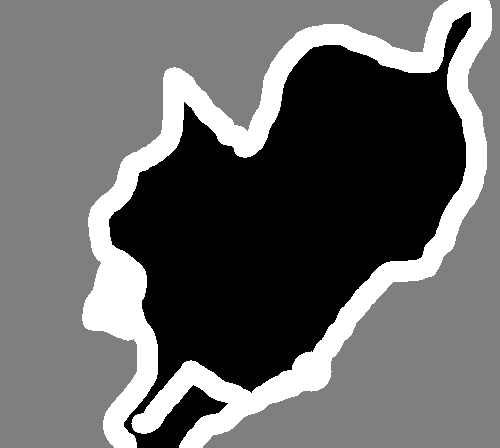

In [28]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
display(Image(filename=input_img_paths[9]))
img = PIL.ImageOps.autocontrast(load_img(get_img_paths[9]))
display(img)

In [40]:
from tensorflow import keras
import numpy
from tensorflow.keras.preprocessing.image import load_img
class OxfordPets(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y =np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] -= 1
        return x, y

In [41]:
from tensorflow.keras import layers
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3, ))
    
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation=x
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation=x
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    model = keras.Model(inputs, outputs)
    return model
keras.backend.clear_session()
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 10, 10, 256)  590080     ['activation_7[0][0]']           
 ose)                                                                                             
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 10, 10, 256)  1024       ['conv2d_transpose[0][0]']       
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 10, 256)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 10, 10, 256)  590080     ['activation_8[0][0]']           
 spose)   

                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 80, 80, 32)  9248        ['activation_14[0][0]']          
 spose)                                                                                           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 80, 80, 32)  128         ['conv2d_transpose_7[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 up_sampling2d_7 (UpSampling2D)  (None, 160, 160, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 up_sampli

In [42]:
import random
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(get_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = get_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = get_img_paths[-val_samples:]
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [43]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 1251s 6s/step - loss: 0.9948 - val_loss: 2.8916
Epoch 2/15
199/199 [==============================] - 952s 5s/step - loss: 0.5134 - val_loss: 2.3163
Epoch 3/15
199/199 [==============================] - 956s 5s/step - loss: 0.4308 - val_loss: 0.4299
Epoch 4/15
199/199 [==============================] - 978s 5s/step - loss: 0.3870 - val_loss: 0.3789
Epoch 5/15
199/199 [==============================] - 972s 5s/step - loss: 0.3522 - val_loss: 0.3894
Epoch 6/15
199/199 [==============================] - 1035s 5s/step - loss: 0.3227 - val_loss: 0.4032
Epoch 7/15
199/199 [==============================] - 1316s 7s/step - loss: 0.2973 - val_loss: 0.4154
Epoch 8/15
199/199 [==============================] - 1326s 7s/step - loss: 0.2764 - val_loss: 0.3811
Epoch 9/15
199/199 [==============================] - 1301s 7s/step - loss: 0.2579 - val_loss: 0.3685
Epoch 10/15
199/199 [==============================] - 968s 5s/step - loss: 0.2409 - v

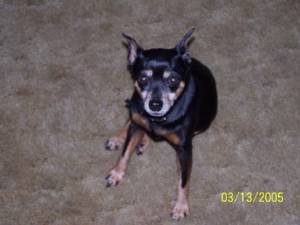

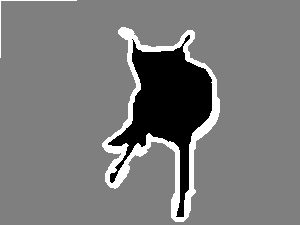

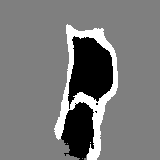

In [44]:
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)
def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)
i = 10
display(Image(filename = val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)

# Project 5

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [5]:
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

In [12]:
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):
    bags = []
    bag_labels = []
    input_data = np.divide(input_data, 255.0)
    count = 0
    for _ in range(bag_count):
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]
        bag_label = 0
        if positive_class in instances_labels:
            bag_label = 1
            count += 1
        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))
    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")
    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()
train_data, train_labels = create_bags(x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE)
val_data, val_labels = create_bags(x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE) 

Positive bags: 294
Negative bags: 706
Positive bags: 89
Negative bags: 211


In [30]:
class MILAttentionLayer(layers.Layer):
    def __init__(self, weight_params_dim, kernel_initializer="glorot_uniform", kernel_regularizer=None, use_gated=False
                , **kwargs):
        super().__init__(**kwargs)
        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer
        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer
    def build(self, input_shape):
        input_dim = input_shape[0][1]
        self.v_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.v_init, 
                                               name="v", regularizer=self.v_regularizer, trainable=True)
        self.w_weight_params = self.add_weight(shape=(self.weight_params_dim, 1), initializer=self.w_init, name="w",
                                              regularizer=self.w_regularizer, trainable=True)
        if self.use_gated:
            self.u_weight_params = self.add_weight(shape=(input_dim, self.weight_params_dim), initializer=self.u_init,
                                                  name="u", regularizer=self.u_regularizer, trainable=True)
        else:
            self.u_weight_params = None
        self.input_built = True
    def call(self, inputs):
        instances = [self.compute_attention_scores(instance) for instance in inputs]
        alpha = tf.math.softmax(instances, axis=0)
        return [alpha[i] for i in range(alpha.shape[0])]
    def compute_attention_scores(self, instance):
        original_instance = instance
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))
        if self.use_gated:
            instance = instance * tf.math.sigmoid(tf.tensordot(original_instance, self.u_weight_params, axes=1))
        return tf.tensordot(instance, self.w_weight_params, axes=1)
    

The bag class label is positive
Bag number: 5


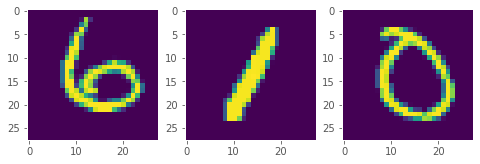

Bag number: 8


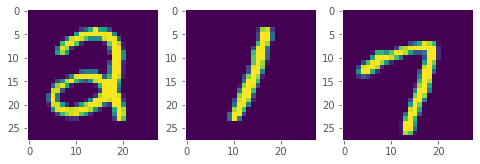

Bag number: 12


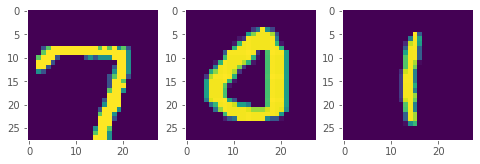

The bag class label is negative
Bag number: 0


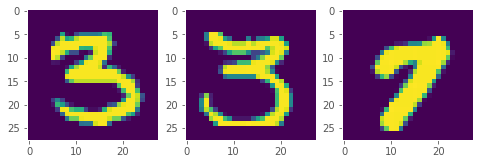

Bag number: 1


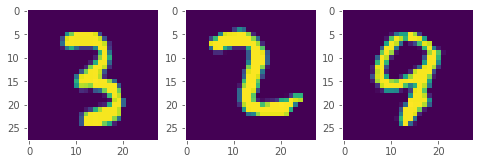

Bag number: 2


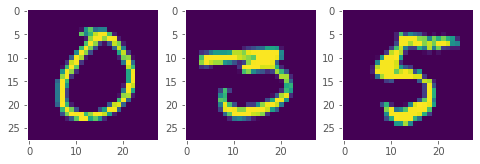

In [53]:
def plot(data, labels, bag_class, predictions=None, attention_weights=None):
    labels = np.array(labels).reshape(-1)
    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
    else:
        print(f"There is no class {bag_class}")
        return
    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()
        
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")

In [49]:
def create_model(instance_shape):
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)
    alpha = MILAttentionLayer(weight_params_dim=256, kernel_regularizer=keras.regularizers.l2(0.01), use_gated=True, 
                             name="alpha")(embeddings)
    multiply_layers = [layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))]
    concat = layers.concatenate(multiply_layers, axis=1)
    output = layers.Dense(2, activation="softmax")(concat)
    return keras.Model(inputs, output)

In [50]:
def compute_class_weights(labels):
    negative_count = len(np.where(labels==0)[0])
    positive_count = len(np.where(labels==1)[0])
    total_count = negative_count + positive_count
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2)
    }

In [51]:
def train(train_data, train_labels, val_data, val_labels, model):
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    model.fit(train_data, train_labels, validation_data = (val_data, val_labels), epochs=20, 
              class_weight=compute_class_weights(train_labels), batch_size=1, callbacks = [early_stopping], verbose=0)
    return model
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]
print(models[0].summary())
trained_models = [train(train_data, train_labels, val_data, val_labels, model) for model in tqdm(models)]

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_24 (Flatten)           (None, 784)          0           ['input_25[0][0]']               
                                                                                           

  0%|          | 0/1 [00:00<?, ?it/s]

None


100%|██████████| 1/1 [00:33<00:00, 33.33s/it]


The average loss and accuracy are 0.03and 99.00 % resp
There is no class postive
The bag class label is negative
Bag number: 0


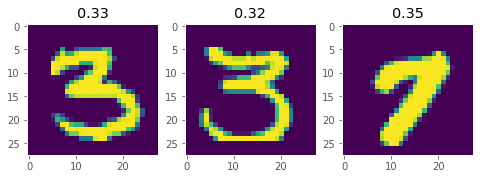

Bag number: 1


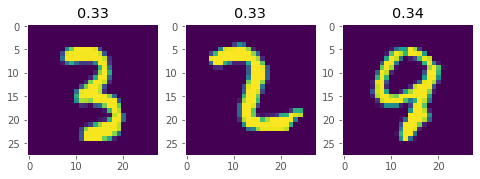

Bag number: 2


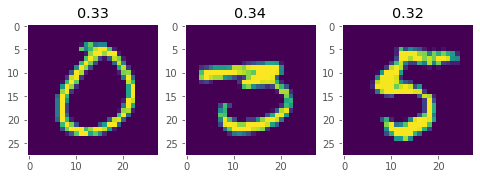

In [54]:
def predict(data, labels, trained_models):
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []
    for model in trained_models:
        predictions = model.predict(data)
        models_predictions.append(predictions)
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)
        intermediate_predictions = intermediate_model.predict(data)
        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)
        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)
    print(f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
         f"and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp")
    return (np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT, 
            np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT)
class_predictions, attention_params = predict(val_data, val_labels, trained_models)
plot(val_data, val_labels, "postive", predictions=class_predictions, attention_weights=attention_params)
plot(val_data, val_labels, "negative", predictions=class_predictions, attention_weights=attention_params)

# Project 6

In [57]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
def preprocess(array):
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array
def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)
def display(array1, array2):
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

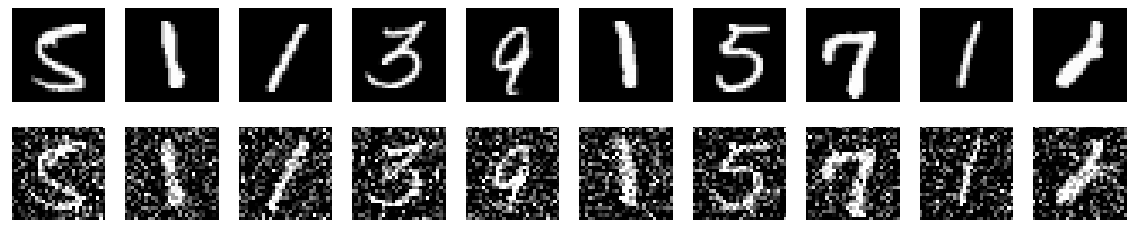

In [58]:
(train_data, _), (test_data, _) = mnist.load_data()
train_data = preprocess(train_data)
test_dat = preprocess(test_data)
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)
display(train_data, noisy_train_data)

In [62]:
input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       924

In [63]:
autoencoder.fit(x=train_data, y=train_data, epochs=50, batch_size=128, shuffle=True, 
                validation_data=(test_data, test_data))

Epoch 1/50
469/469 [==============================] - 96s 203ms/step - loss: 0.1364 - val_loss: -491.0531
Epoch 2/50
469/469 [==============================] - 97s 207ms/step - loss: 0.0718 - val_loss: -495.0501
Epoch 3/50
469/469 [==============================] - 97s 206ms/step - loss: 0.0693 - val_loss: -499.4634
Epoch 4/50
469/469 [==============================] - 97s 207ms/step - loss: 0.0680 - val_loss: -500.7342
Epoch 5/50
469/469 [==============================] - 97s 207ms/step - loss: 0.0673 - val_loss: -503.3451
Epoch 6/50
469/469 [==============================] - 95s 203ms/step - loss: 0.0667 - val_loss: -503.7444
Epoch 7/50
469/469 [==============================] - 96s 206ms/step - loss: 0.0663 - val_loss: -505.6985
Epoch 8/50
469/469 [==============================] - 98s 209ms/step - loss: 0.0659 - val_loss: -506.9315
Epoch 9/50
469/469 [==============================] - 94s 200ms/step - loss: 0.0656 - val_loss: -507.1638
Epoch 10/50
469/469 [=========================

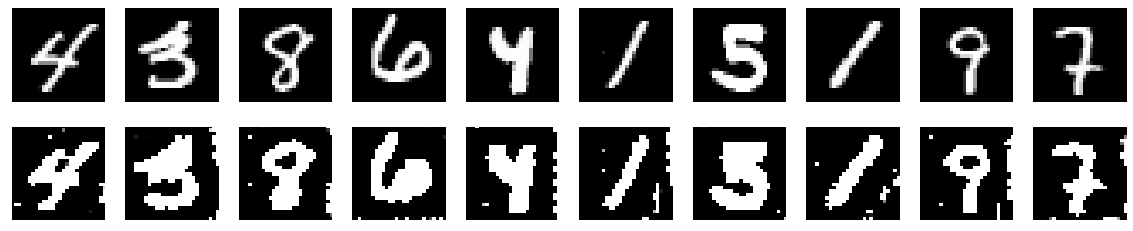

In [65]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [66]:
autoencoder.fit(x=noisy_train_data, y=train_data, epochs=100, batch_size=128, shuffle=True, 
                validation_data=(noisy_test_data, test_data))

Epoch 1/100
469/469 [==============================] - 126s 268ms/step - loss: 0.1008 - val_loss: -131.9158
Epoch 2/100
469/469 [==============================] - 125s 266ms/step - loss: 0.0932 - val_loss: -137.3713
Epoch 3/100
469/469 [==============================] - 127s 270ms/step - loss: 0.0916 - val_loss: -135.3909
Epoch 4/100
469/469 [==============================] - 127s 271ms/step - loss: 0.0907 - val_loss: -143.4165
Epoch 5/100
469/469 [==============================] - 127s 272ms/step - loss: 0.0900 - val_loss: -144.6031
Epoch 6/100
469/469 [==============================] - 126s 268ms/step - loss: 0.0895 - val_loss: -147.1832
Epoch 7/100
469/469 [==============================] - 124s 266ms/step - loss: 0.0890 - val_loss: -149.6535
Epoch 8/100
469/469 [==============================] - 124s 265ms/step - loss: 0.0887 - val_loss: -144.4073
Epoch 9/100
469/469 [==============================] - 124s 265ms/step - loss: 0.0884 - val_loss: -143.4287
Epoch 10/100
469/469 [======

Epoch 77/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0846 - val_loss: -149.4274
Epoch 78/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0846 - val_loss: -153.3381
Epoch 79/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0846 - val_loss: -150.7048
Epoch 80/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0846 - val_loss: -149.6198
Epoch 81/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0846 - val_loss: -149.5244
Epoch 82/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0846 - val_loss: -149.8981
Epoch 83/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0845 - val_loss: -148.6037
Epoch 84/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0845 - val_loss: -153.7423
Epoch 85/100
469/469 [==============================] - 96s 205ms/step - loss: 0.0845 - val_loss: -148.3074
Epoch 86/100
469/469 [======

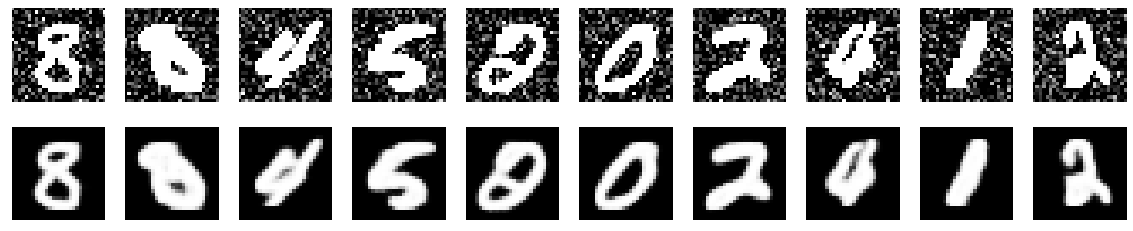

In [67]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)

# Project 7

In [1]:
import os

# slightly faster improvements, on the first epoch 30 second decrease and a 1-2 second
# decrease in epoch time. Overall saves approx. 5 min of training time

# Allocates two threads for a gpu private which allows more operations to be
# done faster
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import tensorflow as tf  # framework
from tensorflow import keras  # for tf.keras
import tensorflow_addons as tfa  # LAMB optimizer and gaussian_blur_2d function
import numpy as np  # np.random.random
import matplotlib.pyplot as plt  # graphs
import datetime  # tensorboard logs naming

# XLA optimization for faster performance(up to 10-15 minutes total time saved)
tf.config.optimizer.set_jit(True)

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
[
    (train_features, train_labels),
    (test_features, test_labels),
] = keras.datasets.cifar10.load_data()

train_features = train_features / 255.0
test_features = test_features / 255.0

In [3]:
# Batch size of dataset
BATCH_SIZE = 512
# Width and height of image
IMAGE_SIZE = 32

In [4]:
class Augmentation(keras.layers.Layer):
    """Base augmentation class.

    Base augmentation class. Contains the random_execute method.

    Methods:
        random_execute: method that returns true or false based
          on a probability. Used to determine whether an augmentation
          will be run.
    """

    def __init__(self):
        super(Augmentation, self).__init__()

    @tf.function
    def random_execute(self, prob: float) -> bool:
        """random_execute function.

        Arguments:
            prob: a float value from 0-1 that determines the
              probability.

        Returns:
            returns true or false based on the probability.
        """

        return tf.random.uniform([], minval=0, maxval=1) < prob


class RandomToGrayscale(Augmentation):
    """RandomToGrayscale class.

    RandomToGrayscale class. Randomly makes an image
    grayscaled based on the random_execute method. There
    is a 20% chance that an image will be grayscaled.

    Methods:
        call: method that grayscales an image 20% of
          the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a grayscaled version of the image 20% of the time
              and the original image 80% of the time.
        """

        if self.random_execute(0.2):
            x = tf.image.rgb_to_grayscale(x)
            x = tf.tile(x, [1, 1, 3])
        return x


class RandomColorJitter(Augmentation):
    """RandomColorJitter class.

    RandomColorJitter class. Randomly adds color jitter to an image.
    Color jitter means to add random brightness, contrast,
    saturation, and hue to an image. There is a 80% chance that an
    image will be randomly color-jittered.

    Methods:
        call: method that color-jitters an image 80% of
          the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Adds color jitter to image, including:
          Brightness change by a max-delta of 0.8
          Contrast change by a max-delta of 0.8
          Saturation change by a max-delta of 0.8
          Hue change by a max-delta of 0.2
        Originally, the same deltas of the original paper
        were used, but a performance boost of almost 2% was found
        when doubling them.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a color-jittered version of the image 80% of the time
              and the original image 20% of the time.
        """

        if self.random_execute(0.8):
            x = tf.image.random_brightness(x, 0.8)
            x = tf.image.random_contrast(x, 0.4, 1.6)
            x = tf.image.random_saturation(x, 0.4, 1.6)
            x = tf.image.random_hue(x, 0.2)
        return x


class RandomFlip(Augmentation):
    """RandomFlip class.

    RandomFlip class. Randomly flips image horizontally. There is a 50%
    chance that an image will be randomly flipped.

    Methods:
        call: method that flips an image 50% of
          the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Randomly flips the image.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a flipped version of the image 50% of the time
              and the original image 50% of the time.
        """

        if self.random_execute(0.5):
            x = tf.image.random_flip_left_right(x)
        return x


class RandomResizedCrop(Augmentation):
    """RandomResizedCrop class.

    RandomResizedCrop class. Randomly crop an image to a random size,
    then resize the image back to the original size.

    Attributes:
        image_size: The dimension of the image

    Methods:
        __call__: method that does random resize crop to the image.
    """

    def __init__(self, image_size):
        super(Augmentation, self).__init__()
        self.image_size = image_size

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Does random resize crop by randomly cropping an image to a random
        size 75% - 100% the size of the image. Then resizes it.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a randomly cropped image.
        """

        rand_size = tf.random.uniform(
            shape=[],
            minval=int(0.75 * self.image_size),
            maxval=1 * self.image_size,
            dtype=tf.int32,
        )

        crop = tf.image.random_crop(x, (rand_size, rand_size, 3))
        crop_resize = tf.image.resize(crop, (self.image_size, self.image_size))
        return crop_resize


class RandomSolarize(Augmentation):
    """RandomSolarize class.

    RandomSolarize class. Randomly solarizes an image.
    Solarization is when pixels accidentally flip to an inverted state.

    Methods:
        call: method that does random solarization 20% of the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Randomly solarizes the image.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a solarized version of the image 20% of the time
              and the original image 80% of the time.
        """

        if self.random_execute(0.2):
            # flips abnormally low pixels to abnormally high pixels
            x = tf.where(x < 10, x, 255 - x)
        return x


class RandomBlur(Augmentation):
    """RandomBlur class.

    RandomBlur class. Randomly blurs an image.

    Methods:
        call: method that does random blur 20% of the time.
    """

    @tf.function
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """call function.

        Randomly solarizes the image.

        Arguments:
            x: a tf.Tensor representing the image.

        Returns:
            returns a blurred version of the image 20% of the time
              and the original image 80% of the time.
        """

        if self.random_execute(0.2):
            s = np.random.random()
            return tfa.image.gaussian_filter2d(image=x, sigma=s)
        return x


class RandomAugmentor(keras.Model):
    """RandomAugmentor class.

    RandomAugmentor class. Chains all the augmentations into
    one pipeline.

    Attributes:
        image_size: An integer represing the width and height
          of the image. Designed to be used for square images.
        random_resized_crop: Instance variable representing the
          RandomResizedCrop layer.
        random_flip: Instance variable representing the
          RandomFlip layer.
        random_color_jitter: Instance variable representing the
          RandomColorJitter layer.
        random_blur: Instance variable representing the
          RandomBlur layer
        random_to_grayscale: Instance variable representing the
          RandomToGrayscale layer
        random_solarize: Instance variable representing the
          RandomSolarize layer

    Methods:
        call: chains layers in pipeline together
    """

    def __init__(self, image_size: int):
        super(RandomAugmentor, self).__init__()

        self.image_size = image_size
        self.random_resized_crop = RandomResizedCrop(image_size)
        self.random_flip = RandomFlip()
        self.random_color_jitter = RandomColorJitter()
        self.random_blur = RandomBlur()
        self.random_to_grayscale = RandomToGrayscale()
        self.random_solarize = RandomSolarize()

    def call(self, x: tf.Tensor) -> tf.Tensor:
        x = self.random_resized_crop(x)
        x = self.random_flip(x)
        x = self.random_color_jitter(x)
        x = self.random_blur(x)
        x = self.random_to_grayscale(x)
        x = self.random_solarize(x)

        x = tf.clip_by_value(x, 0, 1)
        return x


bt_augmentor = RandomAugmentor(IMAGE_SIZE)

In [5]:
class BTDatasetCreator:
    """Barlow twins dataset creator class.

    BTDatasetCreator class. Responsible for creating the
    barlow twins' dataset.

    Attributes:
        options: tf.data.Options needed to configure a setting
          that may improve performance.
        seed: random seed for shuffling. Used to synchronize two
          augmented versions.
        augmentor: augmentor used for augmentation.

    Methods:
        __call__: creates barlow dataset.
        augmented_version: creates 1 half of the dataset.
    """

    def __init__(self, augmentor: RandomAugmentor, seed: int = 1024):
        self.options = tf.data.Options()
        self.options.threading.max_intra_op_parallelism = 1
        self.seed = seed
        self.augmentor = augmentor

    def augmented_version(self, ds: list) -> tf.data.Dataset:
        return (
            tf.data.Dataset.from_tensor_slices(ds)
            .shuffle(1000, seed=self.seed)
            .map(self.augmentor, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(BATCH_SIZE, drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE)
            .with_options(self.options)
        )

    def __call__(self, ds: list) -> tf.data.Dataset:
        a1 = self.augmented_version(ds)
        a2 = self.augmented_version(ds)

        return tf.data.Dataset.zip((a1, a2)).with_options(self.options)


augment_versions = BTDatasetCreator(bt_augmentor)(train_features)

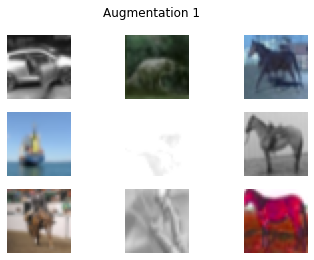

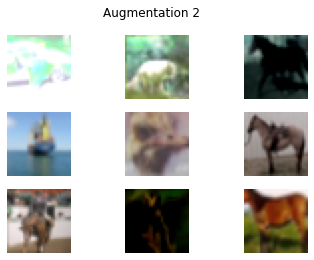

In [6]:
sample_augment_versions = iter(augment_versions)


def plot_values(batch: tuple):
    fig, axs = plt.subplots(3, 3)
    fig1, axs1 = plt.subplots(3, 3)

    fig.suptitle("Augmentation 1")
    fig1.suptitle("Augmentation 2")

    a1, a2 = batch

    # plots images on both tables
    for i in range(3):
        for j in range(3):
            # CHANGE(add / 255)
            axs[i][j].imshow(a1[3 * i + j])
            axs[i][j].axis("off")
            axs1[i][j].imshow(a2[3 * i + j])
            axs1[i][j].axis("off")

    plt.show()


plot_values(next(sample_augment_versions))

In [7]:
class BarlowLoss(keras.losses.Loss):
    """BarlowLoss class.

    BarlowLoss class. Creates a loss function based on the cross-correlation
    matrix.

    Attributes:
        batch_size: the batch size of the dataset
        lambda_amt: the value for lambda(used in cross_corr_matrix_loss)

    Methods:
        __init__: gets instance variables
        call: gets the loss based on the cross-correlation matrix
          make_diag_zeros: Used in calculating off-diagonal section
          of loss function; makes diagonals zeros.
        cross_corr_matrix_loss: creates loss based on cross correlation
          matrix.
    """

    def __init__(self, batch_size: int):
        """__init__ method.

        Gets the instance variables

        Arguments:
            batch_size: An integer value representing the batch size of the
              dataset. Used for cross correlation matrix calculation.
        """

        super(BarlowLoss, self).__init__()
        self.lambda_amt = 5e-3
        self.batch_size = batch_size

    def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
        """get_off_diag method.

        Makes the diagonals of the cross correlation matrix zeros.
        This is used in the off-diagonal portion of the loss function,
        where we take the squares of the off-diagonal values and sum them.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        zero_diag = tf.zeros(c.shape[-1])
        return tf.linalg.set_diag(c, zero_diag)

    def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix_loss method.

        Gets the loss based on the cross correlation matrix.
        We want the diagonals to be 1's and everything else to be
        zeros to show that the two augmented images are similar.

        Loss function procedure:
        take the diagonal of the cross-correlation matrix, subtract by 1,
        and square that value so no negatives.

        Take the off-diagonal of the cc-matrix(see get_off_diag()),
        square those values to get rid of negatives and increase the value,
        and multiply it by a lambda to weight it such that it is of equal
        value to the optimizer as the diagonal(there are more values off-diag
        then on-diag)

        Take the sum of the first and second parts and then sum them together.

        Arguments:
            c: A tf.tensor that represents the cross correlation
              matrix

        Returns:
            Returns a tf.tensor which represents the cross correlation
            matrix with its diagonals as zeros.
        """

        # subtracts diagonals by one and squares them(first part)
        c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)

        # takes off diagonal, squares it, multiplies with lambda(second part)
        off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt

        # sum first and second parts together
        loss = tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)

        return loss

    def normalize(self, output: tf.Tensor) -> tf.Tensor:
        """normalize method.

        Normalizes the model prediction.

        Arguments:
            output: the model prediction.

        Returns:
            Returns a normalized version of the model prediction.
        """

        return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(
            output, axis=0
        )

    def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
        """cross_corr_matrix method.

        Creates a cross correlation matrix from the predictions.
        It transposes the first prediction and multiplies this with
        the second, creating a matrix with shape (n_dense_units, n_dense_units).
        See build_twin() for more info. Then it divides this with the
        batch size.

        Arguments:
            z_a_norm: A normalized version of the first prediction.
            z_b_norm: A normalized version of the second prediction.

        Returns:
            Returns a cross correlation matrix.
        """
        return (tf.transpose(z_a_norm) @ z_b_norm) / self.batch_size

    def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
        """call method.

        Makes the cross-correlation loss. Uses the CreateCrossCorr
        class to make the cross corr matrix, then finds the loss and
        returns it(see cross_corr_matrix_loss()).

        Arguments:
            z_a: The prediction of the first set of augmented data.
            z_b: the prediction of the second set of augmented data.

        Returns:
            Returns a (rank-0) tf.Tensor that represents the loss.
        """

        z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
        c = self.cross_corr_matrix(z_a_norm, z_b_norm)
        loss = self.cross_corr_matrix_loss(c)
        return loss

In [8]:
class ResNet34:
    """Resnet34 class.

        Responsible for the Resnet 34 architecture.
    Modified from
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
    https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/#h2_2.
        View their website for more information.
    """

    def identity_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def convolutional_block(self, x, filter):
        # copy tensor to variable called x_skip
        x_skip = x
        # Layer 1
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same", strides=(2, 2))(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        x = tf.keras.layers.Activation("relu")(x)
        # Layer 2
        x = tf.keras.layers.Conv2D(filter, (3, 3), padding="same")(x)
        x = tf.keras.layers.BatchNormalization(axis=3)(x)
        # Processing Residue with conv(1,1)
        x_skip = tf.keras.layers.Conv2D(filter, (1, 1), strides=(2, 2))(x_skip)
        # Add Residue
        x = tf.keras.layers.Add()([x, x_skip])
        x = tf.keras.layers.Activation("relu")(x)
        return x

    def __call__(self, shape=(32, 32, 3)):
        # Step 1 (Setup Input Layer)
        x_input = tf.keras.layers.Input(shape)
        x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
        # Step 2 (Initial Conv layer along with maxPool)
        x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(x)
        # Define size of sub-blocks and initial filter size
        block_layers = [3, 4, 6, 3]
        filter_size = 64
        # Step 3 Add the Resnet Blocks
        for i in range(4):
            if i == 0:
                # For sub-block 1 Residual/Convolutional block not needed
                for j in range(block_layers[i]):
                    x = self.identity_block(x, filter_size)
            else:
                # One Residual/Convolutional Block followed by Identity blocks
                # The filter size will go on increasing by a factor of 2
                filter_size = filter_size * 2
                x = self.convolutional_block(x, filter_size)
                for j in range(block_layers[i] - 1):
                    x = self.identity_block(x, filter_size)
        # Step 4 End Dense Network
        x = tf.keras.layers.AveragePooling2D((2, 2), padding="same")(x)
        x = tf.keras.layers.Flatten()(x)
        model = tf.keras.models.Model(inputs=x_input, outputs=x, name="ResNet34")
        return model

In [9]:
def build_twin() -> keras.Model:
    """build_twin method.

    Builds a barlow twins model consisting of an encoder(resnet-34)
    and a projector, which generates embeddings for the images

    Returns:
        returns a barlow twins model
    """

    # number of dense neurons in the projector
    n_dense_neurons = 5000

    # encoder network
    resnet = ResNet34()()
    last_layer = resnet.layers[-1].output

    # intermediate layers of the projector network
    n_layers = 2
    for i in range(n_layers):
        dense = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{i}")
        if i == 0:
            x = dense(last_layer)
        else:
            x = dense(x)
        x = tf.keras.layers.BatchNormalization(name=f"projector_bn_{i}")(x)
        x = tf.keras.layers.ReLU(name=f"projector_relu_{i}")(x)

    x = tf.keras.layers.Dense(n_dense_neurons, name=f"projector_dense_{n_layers}")(x)

    model = keras.Model(resnet.input, x)
    return model

In [13]:
class BarlowModel(keras.Model):
    """BarlowModel class.

    BarlowModel class. Responsible for making predictions and handling
    gradient descent with the optimizer.

    Attributes:
        model: the barlow model architecture.
        loss_tracker: the loss metric.

    Methods:
        train_step: one train step; do model predictions, loss, and
            optimizer step.
        metrics: Returns metrics.
    """

    def __init__(self):
        super(BarlowModel, self).__init__()
        self.model = build_twin()
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, batch: tf.Tensor) -> tf.Tensor:
        """train_step method.

        Do one train step. Make model predictions, find loss, pass loss to
        optimizer, and make optimizer apply gradients.

        Arguments:
            batch: one batch of data to be given to the loss function.

        Returns:
            Returns a dictionary with the loss metric.
        """

        # get the two augmentations from the batch
        y_a, y_b = batch

        with tf.GradientTape() as tape:
            # get two versions of predictions
            z_a, z_b = self.model(y_a, training=True), self.model(y_b, training=True)
            loss = self.loss(z_a, z_b)

        grads_model = tape.gradient(loss, self.model.trainable_variables)

        self.optimizer.apply_gradients(zip(grads_model, self.model.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
bm = BarlowModel()

In [ ]:
bm = BarlowModel()
# chose the LAMB optimizer due to high batch sizes. Converged MUCH faster
# than ADAM or SGD
optimizer = tfa.optimizers.LAMB()
loss = BarlowLoss(BATCH_SIZE)

bm.compile(optimizer=optimizer, loss=loss)

# Expected training time: 1 hours 30 min

history = bm.fit(augment_versions, epochs=160)
plt.plot(history.history["loss"])
plt.show()

Epoch 1/160
97/97 [==============================] - 4913s 50s/step - loss: 3388.3677
Epoch 2/160
97/97 [==============================] - 6017s 62s/step - loss: 2194.9070
Epoch 3/160
97/97 [==============================] - 5049s 52s/step - loss: 1959.3861
Epoch 4/160
97/97 [==============================] - 5420s 56s/step - loss: 1825.8740
Epoch 5/160
97/97 [==============================] - 5607s 58s/step - loss: 1732.5812
Epoch 6/160
97/97 [==============================] - 4776s 49s/step - loss: 1657.7670
Epoch 7/160
97/97 [==============================] - 4777s 49s/step - loss: 1600.4021
Epoch 8/160
97/97 [==============================] - 4784s 49s/step - loss: 1559.8276
Epoch 9/160
97/97 [==============================] - 4783s 49s/step - loss: 1535.1239
Epoch 10/160
97/97 [==============================] - 4780s 49s/step - loss: 1487.5593
Epoch 11/160
97/97 [==============================] - 4756s 49s/step - loss: 1459.7209
Epoch 12/160
97/97 [==============================] 

In [14]:
# Approx: 64% accuracy with this barlow twins model.

xy_ds = (
    tf.data.Dataset.from_tensor_slices((train_features, train_labels))
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_features, test_labels))
    .shuffle(1000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

model = keras.models.Sequential(
    [
        bm.model,
        keras.layers.Dense(
            10, activation="softmax", kernel_regularizer=keras.regularizers.l2(0.02)
        ),
    ]
)

model.layers[0].trainable = False

linear_optimizer = tfa.optimizers.LAMB()
model.compile(
    optimizer=linear_optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.fit(xy_ds, epochs=35, validation_data=test_ds)

Epoch 1/35
97/97 [==============================] - 195s 2s/step - loss: 2.6687 - accuracy: 0.1052 - val_loss: 2.6368 - val_accuracy: 0.1289
Epoch 2/35
97/97 [==============================] - 192s 2s/step - loss: 2.6087 - accuracy: 0.1165 - val_loss: 2.5817 - val_accuracy: 0.0997
Epoch 3/35
97/97 [==============================] - 192s 2s/step - loss: 2.5581 - accuracy: 0.1002 - val_loss: 2.5353 - val_accuracy: 0.0996
Epoch 4/35
97/97 [==============================] - 193s 2s/step - loss: 2.5156 - accuracy: 0.1004 - val_loss: 2.4964 - val_accuracy: 0.1001
Epoch 5/35
97/97 [==============================] - 194s 2s/step - loss: 2.4799 - accuracy: 0.1000 - val_loss: 2.4638 - val_accuracy: 0.0998
Epoch 6/35
97/97 [==============================] - 195s 2s/step - loss: 2.4501 - accuracy: 0.1001 - val_loss: 2.4366 - val_accuracy: 0.1000
Epoch 7/35
97/97 [==============================] - 187s 2s/step - loss: 2.4251 - accuracy: 0.1002 - val_loss: 2.4139 - val_accuracy: 0.0993
Epoch 8/35
97

# Project 8

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
SEEDS = 42
np.random.seed(SEEDS)
tf.random.set_seed(SEEDS)

In [16]:
train_ds, validations_ds = tfds.load("tf_flowers", split=["train[:85%]", "train[85%:]"], as_supervised=True)

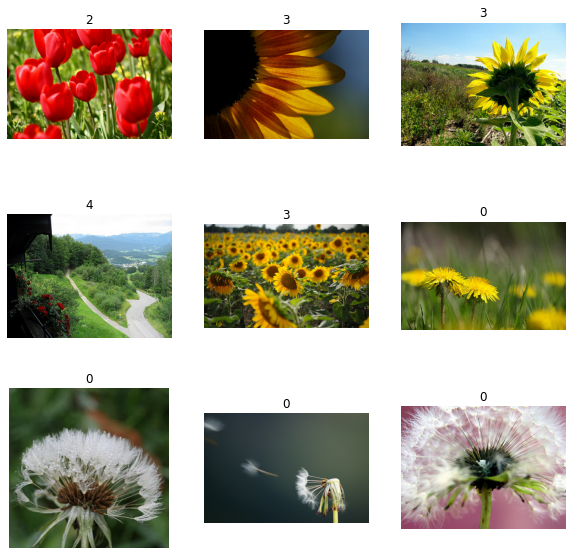

In [17]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [22]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5
SCHEDULE_LENGTH = (500)
SCHEDULE_BOUNDARIES = [200, 300, 400]

In [23]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
@tf.function
def preprocess_train(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = tf.image.random_crop(image, (CROP_TO, CROP_TO, 3))
    image = image / 255.0
    return (image, label)
@tf.function
def preprocess_test(image, label):
    image = tf.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = image / 255.0
    return (image, label)
DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()
repeat_count = int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH)
repeat_count += 50 + 1

In [25]:
pipeline_train = (train_ds.shuffle(10000)
                 .repeat(repeat_count)
                 .map(preprocess_train, num_parallel_calls=AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))
pipeline_validation = (validations_ds.map(preprocess_test, num_parallel_calls=AUTO)
                      .batch(BATCH_SIZE)
                      .prefetch(AUTO))

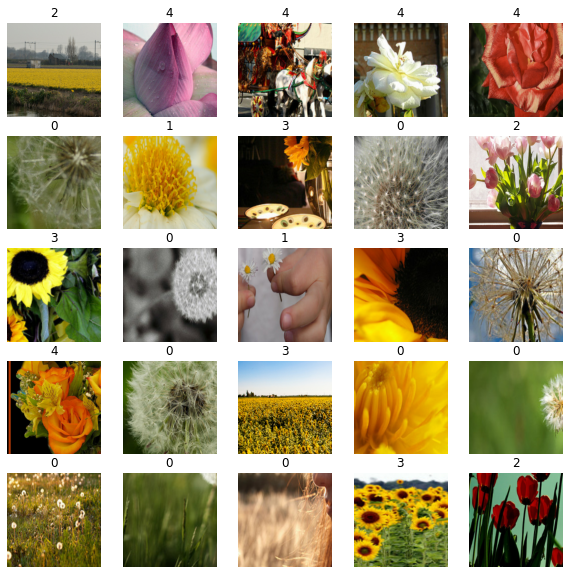

In [26]:
image_batch, label_batch = next(iter(pipeline_train))
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

In [27]:
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.KerasLayer(bit_model_url)

In [29]:
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module
    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)
model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)

In [30]:
learning_rate = 0.003 * BATCH_SIZE / 512
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                               values = [
                                                                   learning_rate, 
                                                                   learning_rate * 0.1,
                                                                   learning_rate * 0.01,
                                                                   learning_rate * 0.001
                                                               ])

In [31]:
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [33]:
train_callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2, restore_best_weights=True)
]

In [35]:
history = model.fit(pipeline_train, batch_size=BATCH_SIZE, epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH), 
                   steps_per_epoch=STEPS_PER_EPOCH, validation_data=pipeline_validation, callbacks=train_callbacks)

Epoch 1/400
10/10 [==============================] - 489s 50s/step - loss: 0.7330 - accuracy: 0.8031 - val_loss: 0.1890 - val_accuracy: 0.9600
Epoch 2/400
10/10 [==============================] - 461s 50s/step - loss: 0.1920 - accuracy: 0.9281 - val_loss: 0.0993 - val_accuracy: 0.9764
Epoch 3/400
10/10 [==============================] - 461s 50s/step - loss: 0.1558 - accuracy: 0.9453 - val_loss: 0.1023 - val_accuracy: 0.9655
Epoch 4/400
10/10 [==============================] - 462s 50s/step - loss: 0.1366 - accuracy: 0.9453 - val_loss: 0.0823 - val_accuracy: 0.9727


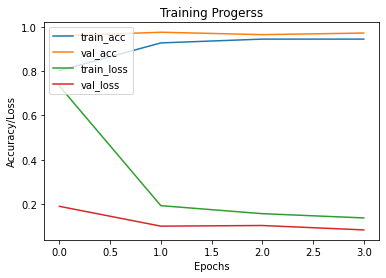

In [38]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progerss")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()
plot_hist(history)

In [39]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

9/9 [==============================] - 335s 37s/step - loss: 0.0993 - accuracy: 0.9764
Accuracy: 97.64%


# Project 9

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers

In [44]:
data_dir = Path("D:/datasets_CSV/captcha_images_v2/")
images = sorted(list(map(str, list(data_dir.glob("*png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", characters)
batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4
max_length = max([len(label) for label in labels])

Number of images found: 1040
Number of labels found: 1040
Number of unique characters: 19
Characters present: {'5', 'w', 'g', '4', 'm', 'n', '8', 'c', '2', '6', 'p', '3', 'f', '7', 'e', 'x', 'b', 'y', 'd'}


In [52]:
char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)
def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return {"image":img, "label":label}

In [54]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE))
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(buffer_size=tf.data.AUTOTUNE))

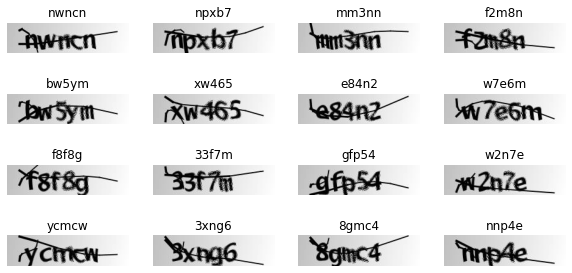

In [55]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [56]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [59]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None, ), dtype="float32")
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", 
                      name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", 
                      name="Conv2")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1 , activation="softmax", name="dense2")(x)
    output = CTCLayer(name="ctc_loss")(labels, x)
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt)
    return model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

In [60]:
epochs = 100
early_stopping_patience=10
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=early_stopping_patience, 
                                               restore_best_weights=True)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping])

Epoch 1/100
59/59 [==============================] - 34s 372ms/step - loss: 20.5520 - val_loss: 16.4407
Epoch 2/100
59/59 [==============================] - 18s 301ms/step - loss: 16.3795 - val_loss: 16.3981
Epoch 3/100
59/59 [==============================] - 18s 303ms/step - loss: 16.3680 - val_loss: 16.3949
Epoch 4/100
59/59 [==============================] - 18s 302ms/step - loss: 16.3561 - val_loss: 16.3920
Epoch 5/100
59/59 [==============================] - 18s 298ms/step - loss: 16.3522 - val_loss: 16.3956
Epoch 6/100
59/59 [==============================] - 18s 297ms/step - loss: 16.3469 - val_loss: 16.3854
Epoch 7/100
59/59 [==============================] - 18s 297ms/step - loss: 16.3385 - val_loss: 16.3820
Epoch 8/100
59/59 [==============================] - 18s 299ms/step - loss: 16.3304 - val_loss: 16.3651
Epoch 9/100
59/59 [==============================] - 18s 297ms/step - loss: 16.3050 - val_loss: 16.3506
Epoch 10/100
59/59 [==============================] - 18s 301ms/

In [61]:
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
prediction_model.summary()
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_length]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            4921

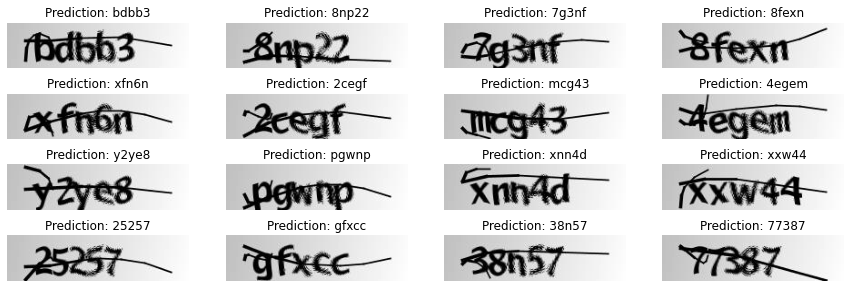

In [62]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

# Project 10

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [24]:
positional_emb = True
conv_layers = 2
projection_dim = 128
num_heads = 2
transformer_units = [projection_dim, projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

In [25]:
num_classes = 10
input_shape = (32, 32, 3)
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape (10000, 10)


In [26]:
class CCTTokenizer(layers.Layer):
    def __init__(self, kernel_size=3, stride=1, padding=1, pooling_kernel_size=3, pooling_stride=2, 
                 num_conv_layers=conv_layers, num_output_channels=[64, 128], positional_emb = positional_emb, **kwargs):
        super(CCTTokenizer, self).__init__(**kwargs)
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(layers.Conv2D(num_output_channels[i], kernel_size, stride, padding="valid", 
                                              use_bias=False, activation="relu", kernel_initializer="he_normal"))
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(layers.MaxPooling2D(pooling_kernel_size, pooling_stride, "same"))
        self.positional_emb = positional_emb
    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(outputs, (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]))
        return reshaped
    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]
            embed_layer = layers.Embedding(input_dim=sequence_length, output_dim=projection_dim)
            return embed_layer, sequence_length
        else:
            return None

In [38]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0], ) + (1, ) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [39]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [40]:
data_augmentation = keras.Sequential([
    layers.Rescaling(scale=1.0 / 255),
    layers.RandomCrop(image_size, image_size),
    layers.RandomFlip("horizontal")
])

In [45]:
def create_cct_model(image_size=image_size, input_shape=input_shape, num_heads=num_heads, projection_dim=projection_dim
                    , transformer_units=transformer_units):
    inputs = layers.Input(input_shape)
    augmented = data_augmentation(inputs)
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embedding = pos_embed(positions)
        encoded_patches += position_embedding
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weight_representation = tf.matmul(attention_weights, representation, transpose_a = True)
    weighted_representation = tf.squeeze(weight_representation, -2)
    logits = layers.Dense(num_classes)(weighted_representation)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [48]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
    model.compile(optimizer=optimizer, loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics = [keras.metrics.CategoricalAccuracy(name="accuracy"), keras.metrics.TopKCategoricalAccuracy(5, 
                                name="top-5-accuracy")]
                 )
    history = model.fit(x=x_train, y = y_train, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
    return history
cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 [==============================] - 389s 1s/step - loss: 1.8719 - accuracy: 0.3505 - top-5-accuracy: 0.8472 - val_loss: 1.6645 - val_accuracy: 0.4610 - val_top-5-accuracy: 0.9148
Epoch 2/30
352/352 [==============================] - 310s 881ms/step - loss: 1.5582 - accuracy: 0.5050 - top-5-accuracy: 0.9346 - val_loss: 1.4659 - val_accuracy: 0.5554 - val_top-5-accuracy: 0.9482
Epoch 3/30
352/352 [==============================] - 311s 884ms/step - loss: 1.4393 - accuracy: 0.5658 - top-5-accuracy: 0.9516 - val_loss: 1.3637 - val_accuracy: 0.6082 - val_top-5-accuracy: 0.9626
Epoch 4/30
352/352 [==============================] - 315s 894ms/step - loss: 1.3660 - accuracy: 0.6024 - top-5-accuracy: 0.9594 - val_loss: 1.3420 - val_accuracy: 0.6088 - val_top-5-accuracy: 0.9624
Epoch 5/30
352/352 [==============================] - 313s 890ms/step - loss: 1.3027 - accuracy: 0.6339 - top-5-accuracy: 0.9660 - val_loss: 1.2775 - val_accuracy: 0.6494 - val_top-5-accuracy: 0.9690
Epo

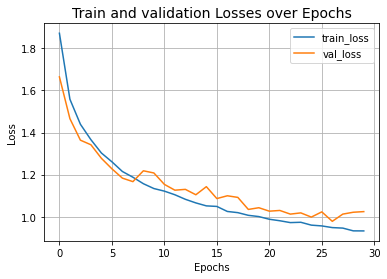

In [49]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and validation Losses over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

# Project 11

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [55]:
fpath = keras.utils.get_file("moving_mnist.npy", 
                             "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy")

819216384/819200096 [==============================] - 1435s 2us/step


In [56]:
dataset = np.load(fpath)
dataset = np.swapaxes(dataset, 0, 1)
dataset = dataset[:1000, ...]
dataset = np.expand_dims(dataset, axis=-1)
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]):]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (900, 19, 64, 64, 1), (900, 19, 64, 64, 1)
Validation Dataset Shapes: (100, 19, 64, 64, 1), (100, 19, 64, 64, 1)


Displaying frames for examples 648


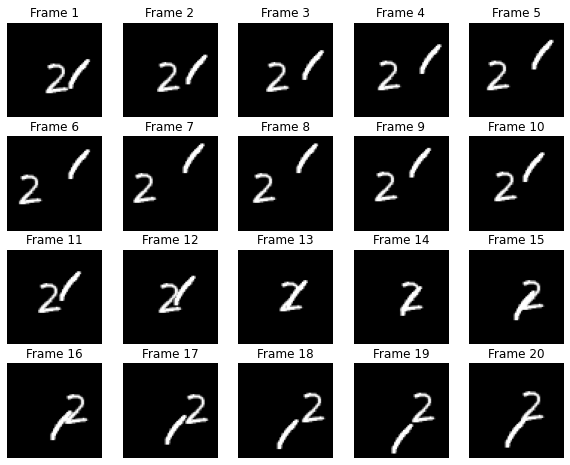

In [57]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(train_dataset[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
print(f"Displaying frames for examples {data_choice}")
plt.show()

In [60]:
inpu = layers.Input(shape=(None, *x_train.shape[2:]))
x = layers.ConvLSTM2D(filters=64, kernel_size=(5, 5), padding="same", return_sequences=True, activation="relu")(inpu)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64, kernel_size=(3, 3), padding="same", return_sequences=True, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64, kernel_size=(1, 1), padding="same", return_sequences=True, activation="relu")(x)
x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)
model = keras.models.Model(inpu, x)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())

In [62]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
epochs = 20
batch_size = 5
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), 
          callbacks=[early_stopping, reduce_lr])

Epoch 1/20
180/180 [==============================] - 5441s 30s/step - loss: 0.0736 - val_loss: 0.2020 - lr: 0.0010
Epoch 2/20
180/180 [==============================] - 5448s 30s/step - loss: 0.0290 - val_loss: 0.1882 - lr: 0.0010
Epoch 3/20
180/180 [==============================] - 5534s 31s/step - loss: 0.0271 - val_loss: 0.0703 - lr: 0.0010
Epoch 4/20
180/180 [==============================] - 5024s 28s/step - loss: 0.0265 - val_loss: 0.0318 - lr: 0.0010
Epoch 5/20
180/180 [==============================] - 4993s 28s/step - loss: 0.0259 - val_loss: 0.0262 - lr: 0.0010
Epoch 6/20
180/180 [==============================] - 5006s 28s/step - loss: 0.0255 - val_loss: 0.0253 - lr: 0.0010
Epoch 7/20
180/180 [==============================] - 5000s 28s/step - loss: 0.0252 - val_loss: 0.0251 - lr: 0.0010
Epoch 8/20
180/180 [==============================] - 5011s 28s/step - loss: 0.0250 - val_loss: 0.0248 - lr: 0.0010
Epoch 9/20
180/180 [==============================] - 4990s 28s/step - l

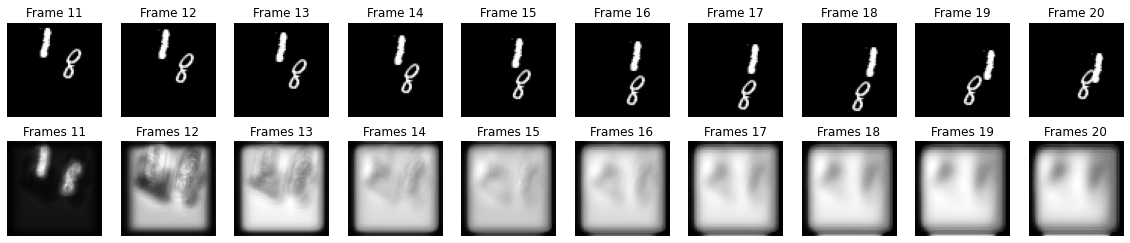

In [65]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]
frames = example[:10, ...]
original_frames = example[10:, ...]
for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)
fig, axes = plt.subplots(2, 10, figsize=(20, 4))
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frames {idx + 11}")
    ax.axis("off")
plt.show()

In [69]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, None, 64, 64, 64)  416256    
                                                                 
 batch_normalization_2 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, None, 64, 64, 64)  295168    
                                                                 
 batch_normalization_3 (Batc  (None, None, 64, 64, 64)  256      
 hNormalization)                                                 
                                                           

# Project 12

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
val_split = 0.1
val_indices = int(len(x_train) * val_split)
new_x_train, new_y_train = x_train[val_indices:], y_train[val_indices:]
x_val, y_val = x_train[:val_indices], y_train[:val_indices]
print(f"Training data samples : {len(new_x_train)}")
print(f"Validation data samples: {len(x_val)}")
print(f"Test data samples: {len(x_test)}")

Training data samples : 45000
Validation data samples: 5000
Test data samples: 10000


In [7]:
image_size = 32
auto = tf.data.AUTOTUNE
data_augmentation = keras.Sequential([layers.RandomCrop(image_size, image_size), layers.RandomFlip("horizontal")]
                                    , name="data_augmentation")
def make_datasets(images, labels, is_train=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10)
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=auto)
    return dataset.prefetch(auto)
train_dataset = make_datasets(new_x_train, new_y_train, is_train=True)
val_dataset = make_datasets(x_val, y_val)
test_dataset = make_datasets(x_test, y_test)

In [8]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])
    
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)
    return x

def get_conv_mixer_256_8(image_size=32, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=10):
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)
    x = conv_stem(x, filters, patch_size)
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [12]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)
    _, accuracy = model.evaluate(test_dataset)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    return history, model

In [13]:
conv_mixer_model = get_conv_mixer_256_8()
history, conv_mixer_model = run_experiment(conv_mixer_model)

Epoch 1/10
352/352 [==============================] - 2464s 7s/step - loss: 1.2085 - accuracy: 0.5692 - val_loss: 4.6343 - val_accuracy: 0.1038
Epoch 2/10
352/352 [==============================] - 2380s 7s/step - loss: 0.7673 - accuracy: 0.7310 - val_loss: 0.7623 - val_accuracy: 0.7320
Epoch 3/10
352/352 [==============================] - 1916s 5s/step - loss: 0.5830 - accuracy: 0.7972 - val_loss: 0.6393 - val_accuracy: 0.7876
Epoch 4/10
352/352 [==============================] - 1922s 5s/step - loss: 0.4731 - accuracy: 0.8363 - val_loss: 0.5703 - val_accuracy: 0.8064
Epoch 5/10
352/352 [==============================] - 1924s 5s/step - loss: 0.4006 - accuracy: 0.8617 - val_loss: 0.4853 - val_accuracy: 0.8326
Epoch 6/10
352/352 [==============================] - 2317s 7s/step - loss: 0.3459 - accuracy: 0.8810 - val_loss: 0.4972 - val_accuracy: 0.8342
Epoch 7/10
352/352 [==============================] - 2452s 7s/step - loss: 0.2975 - accuracy: 0.8964 - val_loss: 0.5351 - val_accuracy:

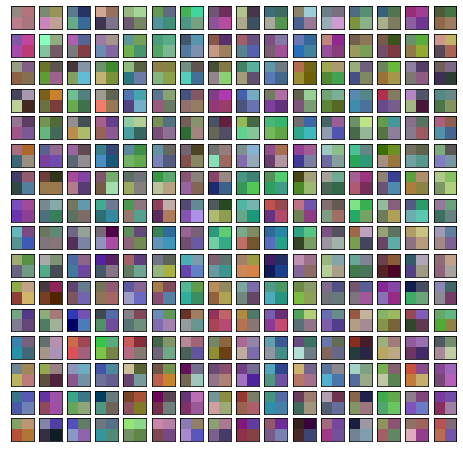

In [15]:
def visualization_plot(weights, idx=1):
    p_min, p_max = weights.min(), weights.max()
    weights = (weights - p_min) / (p_max - p_min)
    num_filters = 256
    plt.figure(figsize=(8, 8))
    for i in range(num_filters):
        current_weight = weights[:, :, :, i]
        if current_weight.shape[-1] == 1:
            current_weight = current_weight.squeeze()
        ax = plt.subplot(16, 16, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(current_weight)
        idx += 1
patch_embeddings = conv_mixer_model.layers[2].get_weights()[0]
visualization_plot(patch_embeddings)

5 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0ADDC70>
12 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0B68040>
19 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0B804C0>
26 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0B931C0>
33 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0BBBB50>
40 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0BE1A90>
47 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0ADDDF0>
54 <keras.layers.convolutional.DepthwiseConv2D object at 0x00000246A0BC6DC0>


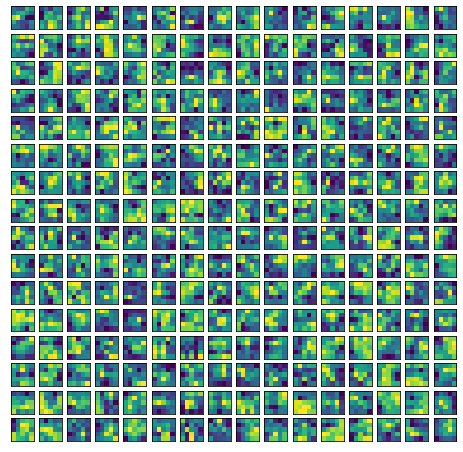

In [17]:
for i, layer in enumerate(conv_mixer_model.layers):
    if isinstance(layer, layers.DepthwiseConv2D):
        if layer.get_config()["kernel_size"] == (5, 5):
            print(i, layer)
idx = 26
kernel = conv_mixer_model.layers[idx].get_weights()[0]
kernel = np.expand_dims(kernel.squeeze(), axis=2)
visualization_plot(kernel)

# Project 13

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

In [20]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [21]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

In [22]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

In [24]:
train_ds_one = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
               .shuffle(1024)
               .map(preprocess_image, num_parallel_calls=AUTO))
train_ds_two = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
               .shuffle(1024)
               .map(preprocess_image, num_parallel_calls=AUTO))
train_ds_sample = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
train_ds_simple = (train_ds_sample.map(preprocess_image, num_parallel_calls=AUTO)
                  .batch(BATCH_SIZE)
                  .prefetch(AUTO))
train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))
test_ds = (test_ds.map(preprocess_image, num_parallel_calls=AUTO)
          .batch(BATCH_SIZE)
          .prefetch(AUTO))

In [25]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)
    cut_w = IMG_SIZE * cut_rat
    cut_w = tf.cast(cut_w, tf.int32)
    
    cut_h = IMG_SIZE * cut_rat
    cut_h = tf.cast(cut_h, tf.int32)
    
    cut_x = tf.random.uniform((1, ), minval=0, maxval=IMG_SIZE, dtype=tf.int32)
    cut_y = tf.random.uniform((1, ), minval=0, maxval=IMG_SIZE, dtype=tf.int32)
    
    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)
    
    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1
    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1
    return boundaryx1, boundaryy1, target_h, target_w


In [26]:
@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two
    alpha = [0.25]
    beta = [0.25]
    lambda_value = sample_beta_distribution(1, alpha, beta)
    lambda_value = lambda_value[0][0]
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)
    crop2 = tf.image.crop_to_bounding_box(image2, boundaryy1, boundaryx1, target_h, target_w)
    image2 = tf.image.pad_to_bounding_box(crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE)
    crop1 = tf.image.crop_to_bounding_box(image1, boundaryy1, boundaryx1, target_h, target_w)
    img1 = tf.image.pad_to_bounding_box(crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE)
    image1 = image1 - img1
    image = image1 + image2
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


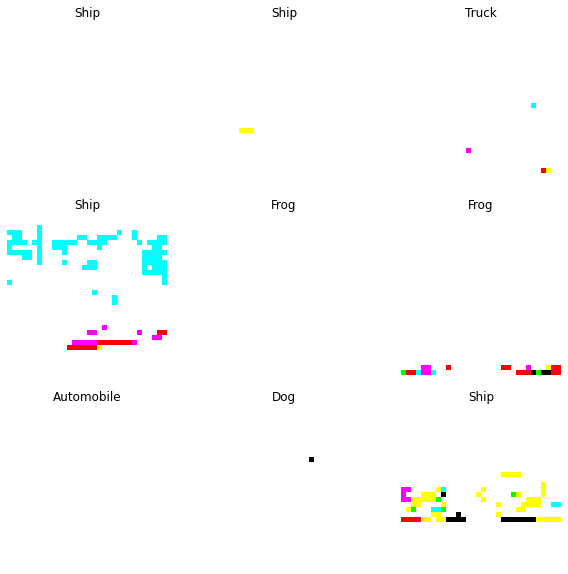

In [36]:
train_ds_mu = (train_ds.shuffle(1024)
               .map(cutmix, num_parallel_calls=AUTO)
               .batch(BATCH_SIZE)
               .prefetch(AUTO))
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize = (10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

In [37]:
def resnet_layer(inputs, num_filters=16, kernel_size = 3, strides=1, activation="relu", batch_normalization=True, 
                 conv_first=True):
    conv = keras.layers.Conv2D(num_filters, kernel_size, strides=strides, padding="same",
                               kernel_initializer="he_normal",
                              kernel_regularizer=keras.regularizers.l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = keras.layers.BatchNormalization()(x)
        if activation is not None:
            x = keras.layers.Activation(activation)(x)
        x = conv(x)
    return x

In [38]:
def resnet_v20(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError("depth should be 6n+2 (eg 20, 32, 44 in [a])")
    num_filters = 16
    num_res_blocks = int((depth-2) / 6)
    inputs = keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:
                strides = 2
            y = resnet_layer(inputs=x, num_filters=num_filters, strides=strides)
            y = resnet_layer(inputs=y, num_filters=num_filters, activation=None)
            if stack > 0 and res_block == 0:
                x = resnet_layer(inputs=x, num_filters=num_filters, kernel_size=1, strides=strides, activation=None, 
                                batch_normalization=False)
            x = keras.layers.add([x, y])
            x = keras.layers.Activation("relu")(x)
        num_filters *= 2
    x = keras.layers.AveragePooling2D(pool_size=8)(x)
    y = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_initializer="he_normal")(y)
    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model
def training_model():
    return resnet_v20((32, 32, 3), 20)
initial_model = training_model()

In [39]:
model = training_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_mu, validation_data=test_ds, epochs=15)
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 564s 357ms/step - loss: 1.9326 - accuracy: 0.4025 - val_loss: 1.6415 - val_accuracy: 0.4899
Epoch 2/15
1563/1563 [==============================] - 501s 320ms/step - loss: 1.6784 - accuracy: 0.5244 - val_loss: 1.1856 - val_accuracy: 0.6429
Epoch 3/15
1563/1563 [==============================] - 507s 324ms/step - loss: 1.5550 - accuracy: 0.5844 - val_loss: 1.0708 - val_accuracy: 0.6832
Epoch 4/15
1563/1563 [==============================] - 524s 335ms/step - loss: 1.4936 - accuracy: 0.6105 - val_loss: 1.0047 - val_accuracy: 0.7141
Epoch 5/15
1563/1563 [==============================] - 503s 322ms/step - loss: 1.4532 - accuracy: 0.6322 - val_loss: 0.9724 - val_accuracy: 0.7203
Epoch 6/15
1563/1563 [==============================] - 519s 332ms/step - loss: 1.4174 - accuracy: 0.6491 - val_loss: 0.9319 - val_accuracy: 0.7411
Epoch 7/15
1563/1563 [==============================] - 496s 317ms/step - loss: 1.3911 - accuracy: 0.6609 - val_

In [40]:
model = training_model()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_ds_simple, validation_data=test_ds, epochs=15)
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test accuracy: {:.2f}".format(test_accuracy * 100))

Epoch 1/15
1563/1563 [==============================] - 674s 428ms/step - loss: 1.4836 - accuracy: 0.5206 - val_loss: 1.3858 - val_accuracy: 0.5582
Epoch 2/15
1563/1563 [==============================] - 672s 430ms/step - loss: 1.0670 - accuracy: 0.6777 - val_loss: 1.1063 - val_accuracy: 0.6719
Epoch 3/15
1563/1563 [==============================] - 521s 333ms/step - loss: 0.8953 - accuracy: 0.7446 - val_loss: 1.0229 - val_accuracy: 0.7089
Epoch 4/15
1563/1563 [==============================] - 500s 320ms/step - loss: 0.7907 - accuracy: 0.7842 - val_loss: 1.1659 - val_accuracy: 0.6941
Epoch 5/15
1563/1563 [==============================] - 499s 319ms/step - loss: 0.7153 - accuracy: 0.8148 - val_loss: 1.2971 - val_accuracy: 0.6780
Epoch 6/15
1563/1563 [==============================] - 502s 321ms/step - loss: 0.6553 - accuracy: 0.8393 - val_loss: 1.2555 - val_accuracy: 0.7092
Epoch 7/15
1563/1563 [==============================] - 501s 320ms/step - loss: 0.6036 - accuracy: 0.8611 - val_

# Project 14

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

C:\Users\jatin\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [30]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


In [31]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [33]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)

In [34]:
def external_attention(
    x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = tf.reshape(
        x, shape=(-1, num_patch, num_heads, dim * dim_coefficient // num_heads)
    )
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True))
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, perm=[0, 2, 1, 3])
    x = tf.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

In [35]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

In [37]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embedding_dim, dropout=attention_dropout
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

In [38]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAvgPool1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [39]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 data_augmentation (Sequential)  (None, 32, 32, 3)   7           ['input_12[0][0]']               
                                                                                                  
 patch_extract_11 (PatchExtract  (None, 256, 12)     0           ['data_augmentation[1][0]']      
 )                                                                                                
                                                                                                  
 patch_embedding_6 (PatchEmbedd  (None, 256, 64)     17216       ['patch_extract_11[0][0]']   

 tf.math.reduce_sum_12 (TFOpLam  (None, 16, 256, 1)  0           ['softmax_13[0][0]']             
 bda)                                                                                             
                                                                                                  
 tf.__operators__.add_12 (TFOpL  (None, 16, 256, 1)  0           ['tf.math.reduce_sum_12[0][0]']  
 ambda)                                                                                           
                                                                                                  
 tf.math.truediv_12 (TFOpLambda  (None, 16, 256, 16)  0          ['softmax_13[0][0]',             
 )                                                                'tf.__operators__.add_12[0][0]']
                                                                                                  
 dropout_45 (Dropout)           (None, 16, 256, 16)  0           ['tf.math.truediv_12[0][0]']     
          

                                                                                                  
 dense_88 (Dense)               (None, 256, 64)      4160        ['layer_normalization_28[0][0]'] 
                                                                                                  
 dropout_51 (Dropout)           (None, 256, 64)      0           ['dense_88[0][0]']               
                                                                                                  
 dense_89 (Dense)               (None, 256, 64)      4160        ['dropout_51[0][0]']             
                                                                                                  
 dropout_52 (Dropout)           (None, 256, 64)      0           ['dense_89[0][0]']               
                                                                                                  
 add_25 (Add)                   (None, 256, 64)      0           ['dropout_52[0][0]',             
          

 bda)                                                                                             
                                                                                                  
 tf.__operators__.add_15 (TFOpL  (None, 16, 256, 1)  0           ['tf.math.reduce_sum_15[0][0]']  
 ambda)                                                                                           
                                                                                                  
 tf.math.truediv_15 (TFOpLambda  (None, 16, 256, 16)  0          ['softmax_16[0][0]',             
 )                                                                'tf.__operators__.add_15[0][0]']
                                                                                                  
 dropout_57 (Dropout)           (None, 16, 256, 16)  0           ['tf.math.truediv_15[0][0]']     
                                                                                                  
 dense_98 

 dense_106 (Dense)              (None, 256, 64)      4160        ['layer_normalization_34[0][0]'] 
                                                                                                  
 dropout_63 (Dropout)           (None, 256, 64)      0           ['dense_106[0][0]']              
                                                                                                  
 dense_107 (Dense)              (None, 256, 64)      4160        ['dropout_63[0][0]']             
                                                                                                  
 dropout_64 (Dropout)           (None, 256, 64)      0           ['dense_107[0][0]']              
                                                                                                  
 add_31 (Add)                   (None, 256, 64)      0           ['dropout_64[0][0]',             
                                                                  'add_30[0][0]']                 
          

                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 16, 256, 1)  0           ['tf.math.reduce_sum_18[0][0]']  
 ambda)                                                                                           
                                                                                                  
 tf.math.truediv_18 (TFOpLambda  (None, 16, 256, 16)  0          ['softmax_19[0][0]',             
 )                                                                'tf.__operators__.add_18[0][0]']
                                                                                                  
 dropout_69 (Dropout)           (None, 16, 256, 16)  0           ['tf.math.truediv_18[0][0]']     
                                                                                                  
 dense_116 (Dense)              (None, 16, 256, 16)  272         ['dropout_69[0][0]']             
          

In [42]:
model = get_model(attention_type="external_attention")
model.compile(loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing), 
              optimizer=tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay), metrics=[
                  keras.metrics.CategoricalAccuracy(name="accuracy"),
                  keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy")
              ])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_split=validation_split)

Epoch 1/50
313/313 [==============================] - 2571s 8s/step - loss: 4.2100 - accuracy: 0.0728 - top-5-accuracy: 0.2373 - val_loss: 4.0290 - val_accuracy: 0.1114 - val_top-5-accuracy: 0.3262
Epoch 2/50
313/313 [==============================] - 2695s 9s/step - loss: 3.8162 - accuracy: 0.1411 - top-5-accuracy: 0.3810 - val_loss: 3.7786 - val_accuracy: 0.1679 - val_top-5-accuracy: 0.4203
Epoch 3/50
313/313 [==============================] - 2580s 8s/step - loss: 3.5674 - accuracy: 0.1961 - top-5-accuracy: 0.4740 - val_loss: 3.6730 - val_accuracy: 0.1981 - val_top-5-accuracy: 0.4760
Epoch 4/50
313/313 [==============================] - 2092s 7s/step - loss: 3.4048 - accuracy: 0.2342 - top-5-accuracy: 0.5293 - val_loss: 3.4452 - val_accuracy: 0.2421 - val_top-5-accuracy: 0.5373
Epoch 5/50
313/313 [==============================] - 2078s 7s/step - loss: 3.2947 - accuracy: 0.2639 - top-5-accuracy: 0.5664 - val_loss: 3.3253 - val_accuracy: 0.2628 - val_top-5-accuracy: 0.5688
Epoch 6/50

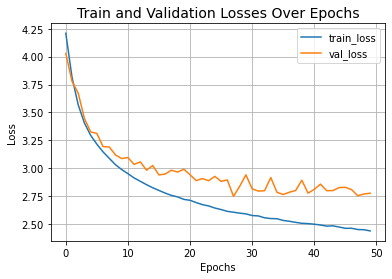

In [43]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [44]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy : {round(accuracy * 100, 2)}")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}")

313/313 [==============================] - 146s 466ms/step - loss: 2.7559 - accuracy: 0.4331 - top-5-accuracy: 0.7488
Test loss: 2.76
Test accuracy : 43.31
Test top 5 accuracy: 74.88


# 

# Project 15

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import matplotlib.pyplot as plt

In [2]:
train_dataset, val_dataset = tfds.load("tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


In [3]:
batch_size = 128
auto = tf.data.AUTOTUNE
smaller_size = 128
bigger_size = 224
size_for_resizing = int((bigger_size / smaller_size) * bigger_size)
central_crop_layer = layers.CenterCrop(bigger_size, bigger_size)
def preprocess_initial(train, image_size):
    def _pp(image, label, train):
        if train:
            channels = image.shape[-1]
            begin, size, _ = tf.image.sample_distorted_bounding_box(tf.shape(image), tf.zeros([0, 0, 4], tf.float32),
                                                                   area_range=(0.05, 1.0), min_object_covered=0, 
                                                                    use_image_if_no_bounding_boxes=True)
            image = tf.slice(image, begin, size)
            image.set_shape([None, None, channels])
            image = tf.image.resize(image, [image_size, image_size])
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, [image_size, image_size])
        return image, label
    return _pp

def preprocess_finetune(image, label, train):
    image = tf.image.resize(image, [size_for_resizing, size_for_resizing])
    if train:
        image = tf.image.random_flip_left_right(image)
    image = central_crop_layer(image[None, ...])[0]
    return image, label

def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = smaller_size, 
                 fixres: bool = True, num_parallel_calls=auto):
    if image_size not in [smaller_size, bigger_size]:
        raise ValueError(f"{image_size} resolution not supported")
    if image_size == smaller_size:
        preprocess_func = preprocess_initial(train, image_size)
    elif not fixres and image_size == bigger_size:
        preprocess_func = preprocess_initial(train, image_size)
    else:
        preprocess_func = preprocess_finetune
    if train:
        dataset = dataset.shuffle(batch_size * 10)
    return (dataset.map(lambda x, y: preprocess_func(x, y, train), num_parallel_calls=num_parallel_calls)
           .batch(batch_size)
           .prefetch(num_parallel_calls))

In [4]:
initial_train_dataset = make_dataset(train_dataset, train=True, image_size=smaller_size)
intial_val_dataset = make_dataset(val_dataset, train=False, image_size=smaller_size)
finetune_train_dataset = make_dataset(train_dataset, train=True, image_size=bigger_size)
finetune_val_dataset = make_dataset(val_dataset, train=False, image_size=bigger_size)
vanilla_train_dataset = make_dataset(train_dataset, train=True, image_size=bigger_size, fixres=False)
vanilla_val_dataset = make_dataset(val_dataset, train=False, image_size=bigger_size, fixres=False)

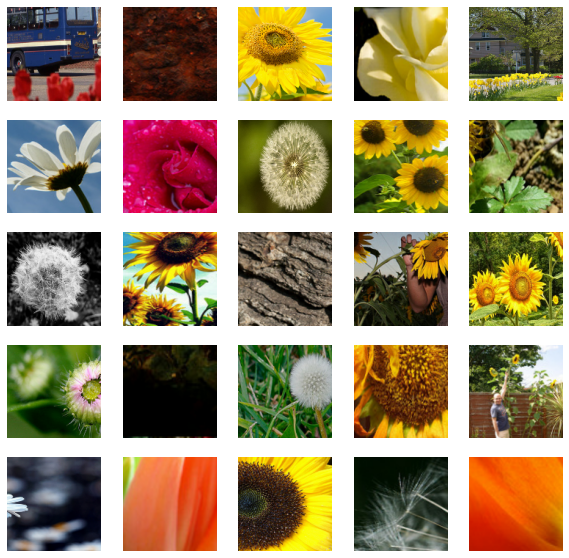

Batch shape: (128, 128, 128, 3).


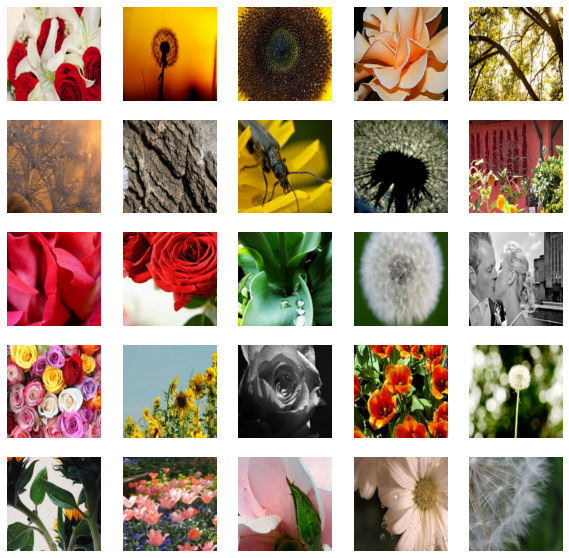

Batch shape: (128, 224, 224, 3).


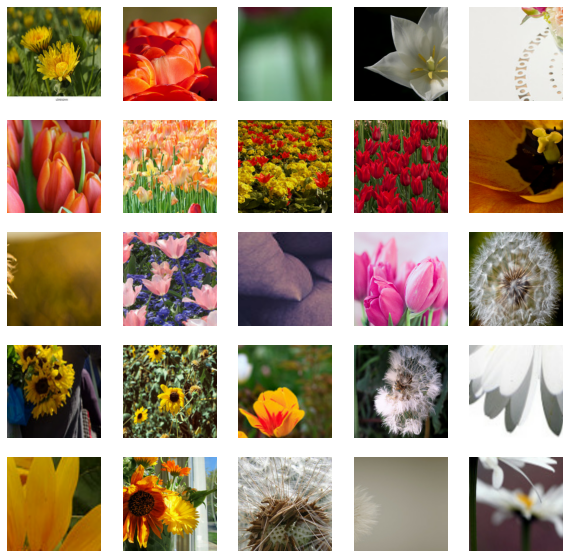

Batch shape: (128, 224, 224, 3).


In [5]:
def visualize_dataset(batch_images):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(batch_images[n].numpy().astype("int"))
        plt.axis("off")
    plt.show()
    print(f"Batch shape: {batch_images.shape}.")
initial_sample_images, _ = next(iter(initial_train_dataset))
visualize_dataset(initial_sample_images)

finetune_sample_images, _ = next(iter(finetune_train_dataset))
visualize_dataset(finetune_sample_images)

vanilla_sample_images, _ = next(iter(vanilla_train_dataset))
visualize_dataset(vanilla_sample_images)

In [10]:
def get_training_model(num_classes=5):
    inputs = layers.Input((None, None, 3))
    resnet_base = keras.applications.ResNet50V2(include_top=False, weights=None, pooling="avg")
    resnet_base.trainable = True
    x = layers.Rescaling(scale=1.0 / 127.5, offset=-1)(inputs)
    x = resnet_base(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

def train_and_evaluate(model, train_ds, val_ds, epochs, learning_rate=1e-3, use_early_stopping=False):
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    if use_early_stopping:
        es_callback = keras.callbacks.EarlyStopping(patience=5)
        callbacks = [es_callback]
    else:
        callbacks = None
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    _, accuracy = model.evaluate(val_ds)
    print(f"Top-1 accuracy on the validation set: {accuracy * 100:.2f}%")
    return model

In [11]:
epochs = 30
smaller_res_model = get_training_model()
smaller_res_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 rescaling (Rescaling)       (None, None, None, 3)     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 23,529,605
Non-trainable params: 45,440
_________________________________________________________________


In [15]:
smaller_res_model = train_and_evaluate(smaller_res_model, initial_train_dataset, intial_val_dataset, epochs)

Epoch 1/30
26/26 [==============================] - 578s 22s/step - loss: 1.5706 - accuracy: 0.4363 - val_loss: 3.1408 - val_accuracy: 0.1907
Epoch 2/30
26/26 [==============================] - 565s 22s/step - loss: 1.1666 - accuracy: 0.5407 - val_loss: 2.2612 - val_accuracy: 0.1826
Epoch 3/30
26/26 [==============================] - 564s 22s/step - loss: 1.0788 - accuracy: 0.5901 - val_loss: 2.2290 - val_accuracy: 0.2071
Epoch 4/30
26/26 [==============================] - 565s 22s/step - loss: 0.9996 - accuracy: 0.6158 - val_loss: 2.4303 - val_accuracy: 0.1989
Epoch 5/30
26/26 [==============================] - 519s 20s/step - loss: 0.9968 - accuracy: 0.6194 - val_loss: 2.4314 - val_accuracy: 0.2289
Epoch 6/30
26/26 [==============================] - 422s 16s/step - loss: 0.9809 - accuracy: 0.6237 - val_loss: 2.1437 - val_accuracy: 0.2534
Epoch 7/30
26/26 [==============================] - 421s 16s/step - loss: 0.9185 - accuracy: 0.6512 - val_loss: 1.9111 - val_accuracy: 0.2861
Epoch 

In [16]:
for layer in smaller_res_model.layers[2].layers:
    layer.trainable=False
smaller_res_model.layers[2].get_layer("post_bn").trainable=True
epochs = 10
biggger_res_model = train_and_evaluate(smaller_res_model, finetune_train_dataset, finetune_val_dataset, epochs, 
                                       learning_rate=1e-4)

Epoch 1/10
26/26 [==============================] - 277s 11s/step - loss: 1.0521 - accuracy: 0.7203 - val_loss: 0.8787 - val_accuracy: 0.7302
Epoch 2/10
26/26 [==============================] - 266s 10s/step - loss: 1.0149 - accuracy: 0.7012 - val_loss: 0.9122 - val_accuracy: 0.7357
Epoch 3/10
26/26 [==============================] - 266s 10s/step - loss: 0.9995 - accuracy: 0.7145 - val_loss: 0.9273 - val_accuracy: 0.7384
Epoch 4/10
26/26 [==============================] - 264s 10s/step - loss: 0.9953 - accuracy: 0.7063 - val_loss: 0.9359 - val_accuracy: 0.7357
Epoch 5/10
26/26 [==============================] - 264s 10s/step - loss: 0.9809 - accuracy: 0.7097 - val_loss: 0.9410 - val_accuracy: 0.7302
Epoch 6/10
26/26 [==============================] - 265s 10s/step - loss: 0.9690 - accuracy: 0.7109 - val_loss: 0.9445 - val_accuracy: 0.7357
Epoch 7/10
26/26 [==============================] - 263s 10s/step - loss: 0.9649 - accuracy: 0.7196 - val_loss: 0.9388 - val_accuracy: 0.7357
Epoch 

In [17]:
epochs = 30
vanilla_bigger_res_model = get_training_model()
vanilla_bigger_res_model = train_and_evaluate(vanilla_bigger_res_model, vanilla_train_dataset, vanilla_val_dataset
                                             , epochs)

Epoch 1/30
26/26 [==============================] - 2572s 99s/step - loss: 1.5750 - accuracy: 0.4323 - val_loss: 257.2557 - val_accuracy: 0.2044
Epoch 2/30
26/26 [==============================] - 2821s 108s/step - loss: 1.1812 - accuracy: 0.5392 - val_loss: 5.2226 - val_accuracy: 0.2234
Epoch 3/30
26/26 [==============================] - 2744s 105s/step - loss: 1.1018 - accuracy: 0.5789 - val_loss: 1.9627 - val_accuracy: 0.2044
Epoch 4/30
26/26 [==============================] - 2779s 107s/step - loss: 1.0330 - accuracy: 0.6088 - val_loss: 2.2321 - val_accuracy: 0.2589
Epoch 5/30
26/26 [==============================] - 2712s 104s/step - loss: 1.0182 - accuracy: 0.6107 - val_loss: 2.1733 - val_accuracy: 0.3787
Epoch 6/30
26/26 [==============================] - 2663s 102s/step - loss: 0.9769 - accuracy: 0.6228 - val_loss: 1.6352 - val_accuracy: 0.3188
Epoch 7/30
26/26 [==============================] - 2650s 102s/step - loss: 0.9472 - accuracy: 0.6261 - val_loss: 1.9162 - val_accuracy